# Embedding Model 만들기

In [636]:
#Dependencies
import pandas as pd
import numpy as np
import tensorflow as tf
import itertools
import matplotlib.pyplot as plt
import time

from envs import OfflineEnv
from recommender import DRRAgent
import csv
import os

import logging, os

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import plotly.express as px
import tqdm


ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, 'ml-1m/')
STATE_SIZE = 10
MAX_EPISODE_NUM = 10

In [637]:
def custom_read_data(file_path):
    with open(file_path, 'r', encoding='latin-1') as file:
        # Skip the header or manage accordingly if there's no header
        next(file)  # Uncomment this line if there's a header
        data = []
        for line in file:
            parts = line.strip().split('"')
            if len(parts) < 5:
                while len(parts) < 5:
                    parts.append("-")
            # Rejoin incorrectly split parts for Title or AggregatedTags
            id_title = parts[0].strip().split(":")
            movie_id = int(id_title[0])
            title = id_title[1]  # Assumes title is the field being split incorrectly
            genres = parts[1]
            year = parts[2].split(":")[1][:4]
            aggregated_tags = parts[-2]
            data.append([movie_id, title, genres, year, aggregated_tags])
            
    return data

In [638]:
#### Loading datasets
ratings_list = [[int(x) if x.isdigit() else 0 for x in i.strip().split("::")] for i in open(os.path.join(DATA_DIR, 'ratings.dat'), 'r').readlines()]
users_list = [i.strip().split("::") for i in open(os.path.join(DATA_DIR,'users.dat'), 'r').readlines()]
# ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = np.uint32)
ratings_df = pd.DataFrame(ratings_list, columns=['UserID', 'MovieID', 'Rating', 'Timestamp'])
ratings_df['UserID'] = ratings_df['UserID'].astype(np.uint32)
ratings_df['MovieID'] = ratings_df['MovieID'].astype(np.uint32)
ratings_df['Rating'] = ratings_df['Rating'].astype(np.uint32)
ratings_df['Timestamp'] = ratings_df['Timestamp'].astype(np.uint32)
movies_data = custom_read_data(os.path.join(DATA_DIR, 'merged_movies.dat'))
movies_df = pd.DataFrame(movies_data, columns=['MovieID', 'Title', 'Genres', 'Year', 'AggregatedTags'])

print("Data loading complete!")
print("Data preprocessing...")
print(movies_df.head())

Data loading complete!
Data preprocessing...
   MovieID                               Title                        Genres  \
0        2                      Jumanji (1995)  Adventure:Children's:Fantasy   
1        3             Grumpier Old Men (1995)                Comedy:Romance   
2        4            Waiting to Exhale (1995)                  Comedy:Drama   
3        5  Father of the Bride Part II (1995)                        Comedy   
4        6                         Heat (1995)         Action:Crime:Thriller   

   Year                                     AggregatedTags  
0  1995  29:adventure:0.9760:204:children:0.9590:377:fa...  
1  1995  901:sequel:0.9752:451:good sequel:0.9625:902:s...  
2  1995  1116:women:0.9752:201:chick flick:0.8990:313:d...  
3  1995  901:sequel:0.9603:451:good sequel:0.9540:383:f...  
4  1995  268:crime:0.9798:498:heist:0.9570:105:bank rob...  


In [639]:
# 영화 id를 영화 제목으로
movies_id_to_movies = {movie[0]: movie[1:] for movie in movies_data}

In [640]:
movies_df.head(5)

,MovieID,Title,Genres,Year,AggregatedTags
0,2,Jumanji (1995),Adventure:Children's:Fantasy,1995,29:adventure:0.9760:204:children:0.9590:377:fa...
1,3,Grumpier Old Men (1995),Comedy:Romance,1995,901:sequel:0.9752:451:good sequel:0.9625:902:s...
2,4,Waiting to Exhale (1995),Comedy:Drama,1995,1116:women:0.9752:201:chick flick:0.8990:313:d...
3,5,Father of the Bride Part II (1995),Comedy,1995,901:sequel:0.9603:451:good sequel:0.9540:383:f...
4,6,Heat (1995),Action:Crime:Thriller,1995,268:crime:0.9798:498:heist:0.9570:105:bank rob...


In [641]:
ratings_df.head(5)

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [642]:
genres = ['Action',
        'Adventure',
        'Animation',
        "Children's",
        'Comedy',
        'Crime',
        'Documentary',
        'Drama',
        'Fantasy',
        'Film-Noir',
        'Horror',
        'Musical',
        'Mystery',
        'Romance',
        'Sci-Fi',
        'Thriller',
        'War',
        'Western']

영화와 장르간의 상관관계, 영화와 유저와의 상관관계를 이용해 영화, 장르, 유저의 임배딩을 만들자.

영화-장르의 임배딩을 먼저 학습 후, 학습된 영화 임배딩을 이용해 영화-유저의 임배딩을 학습

## 영화, 장르, 유저 dataframe만들기

In [643]:
# 영화id와 genres dataframe 만들기
movies_genres_df = movies_df[['MovieID', 'Genres', 'AggregatedTags']]

In [644]:
movies_genres_df.head(5)

,MovieID,Genres,AggregatedTags
0,2,Adventure:Children's:Fantasy,29:adventure:0.9760:204:children:0.9590:377:fa...
1,3,Comedy:Romance,901:sequel:0.9752:451:good sequel:0.9625:902:s...
2,4,Comedy:Drama,1116:women:0.9752:201:chick flick:0.8990:313:d...
3,5,Comedy,901:sequel:0.9603:451:good sequel:0.9540:383:f...
4,6,Action:Crime:Thriller,268:crime:0.9798:498:heist:0.9570:105:bank rob...


In [645]:
# 각 영화별 Gneres 분할 후 인덱싱
def _split_and_index(string):
    string = string.split(':')
    for i, s in enumerate(string):
        string[i] = genres.index(s)
    return string
movies_genres_df.loc[:, 'Genres'] = movies_genres_df['Genres'].map(lambda x: _split_and_index(x))

In [646]:
# # movie tags
def _parse_and_index_tags(tag_string):
    # Split the aggregated tags string by '|'
    if tag_string == "-":
        return [-1]
    tags = tag_string.split(':')
    parsed_tags = []
    for tag in tags[::3]:
        if "." not in tag and not tag.isalpha():
            # Each component is separated by ':', where the first part is the tag ID
            parsed_tags.append(int(tag))
    return parsed_tags
movies_genres_df.loc[:, 'AggregatedTags'] = movies_genres_df['AggregatedTags'].map(lambda x: _parse_and_index_tags(x))
all_unique_tags = set().union(*movies_genres_df['AggregatedTags'])
# To see a few of the sets:
print(movies_genres_df['AggregatedTags'].head())


3877    230:comedy:0.9870:505:hilarious:0.9500:1071:ve...
3878    329:drug abuse:0.9948:330:drug addiction:0.992...
3879    1080:vietnam war:0.9433:127:best war films:0.9...
3880    277:culture clash:0.9597:564:irish accent:0.90...
3881    1119:world politics:0.9968:800:politics:0.9898...
Name: AggregatedTags, dtype: object
0      [29, 204, 377, 588, 951]
1     [901, 451, 902, 230, 742]
2    [1116, 201, 313, 439, 864]
3     [901, 451, 383, 902, 808]
4      [268, 498, 105, 465, 19]
Name: AggregatedTags, dtype: object


In [ ]:
all_unique_tags = list(all_unique_tags)

In [648]:
def _split_tag_index(string):
    for i, s in enumerate(string):
        string[i] = all_unique_tags.index(s)
    return string
movies_genres_df.loc[:, 'AggregatedTags'] = movies_genres_df['AggregatedTags'].map(lambda x: _split_tag_index(x))

In [649]:
movies_genres_df['AggregatedTags']

0        [26, 177, 319, 501, 819]
1       [774, 385, 775, 199, 634]
2       [959, 174, 270, 376, 741]
3       [774, 385, 325, 775, 690]
4         [228, 422, 88, 396, 16]
                  ...            
3877    [199, 426, 921, 354, 355]
3878     [282, 283, 22, 284, 642]
3879    [927, 109, 560, 942, 471]
3880    [236, 481, 480, 896, 527]
3881    [962, 683, 681, 693, 682]
Name: AggregatedTags, Length: 3882, dtype: object

In [651]:
exploded_tag_ids = movies_genres_df['AggregatedTags'].explode()

# Step 2: Use pd.unique to find unique tag IDs
unique_tag_ids = pd.unique(exploded_tag_ids)

# Print the number of unique tag IDs
print(f"Number of unique tag IDs: {len(unique_tag_ids)}")
tags = max(unique_tag_ids)

Number of unique tag IDs: 972


In [652]:
movies_genres_df.head(5)

,MovieID,Genres,AggregatedTags
0,2,"[1, 3, 8]","[26, 177, 319, 501, 819]"
1,3,"[4, 13]","[774, 385, 775, 199, 634]"
2,4,"[4, 7]","[959, 174, 270, 376, 741]"
3,5,[4],"[774, 385, 325, 775, 690]"
4,6,"[0, 5, 15]","[228, 422, 88, 396, 16]"


In [653]:
# 결측값 확인
movies_genres_df.isnull().sum()

MovieID           0
Genres            0
AggregatedTags    0
dtype: int64

In [654]:
# 고유값 확인
len(movies_df['MovieID'])

3882

In [655]:
len(movies_genres_df['AggregatedTags'])

3882

In [656]:
movies_genres_df['MovieID'].nunique()

3882

In [657]:
# 유저별 영화 rating dataframe 만들기
user_movie_rating_df = ratings_df[['UserID','MovieID','Rating']]

In [658]:
user_movie_rating_df.head(5)

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [659]:
# 결측값 확인
user_movie_rating_df.isnull().sum()

UserID     0
MovieID    0
Rating     0
dtype: int64

In [660]:
user_movie_rating_df['UserID'].nunique()

6040

In [661]:
user_movie_rating_df['MovieID'].nunique()

3706

##  Case1. 

## 모델 만들기

In [662]:
from tensorflow.keras.layers import InputLayer, Embedding, Dot, Reshape, Dense
from tensorflow.keras.models import Model

### Movie Genre Embedding 모델 

In [663]:
class MovieGenreEmbedding(tf.keras.Model):
    def __init__(self, len_movies, len_genres, embedding_size):
        super(MovieGenreEmbedding, self).__init__()
        self.m_g_t_input = InputLayer(name='input_layer', input_shape=(3,))
        # embedding
        self.m_embedding = Embedding(name='movie_embedding', input_dim=len_movies, output_dim=embedding_size)
        self.g_embedding = Embedding(name='genre_embedding', input_dim=len_genres, output_dim=embedding_size)
        # dot product
        self.m_g_merge = Dot(name='movie_genre_dot', normalize=True, axes=1)
        # output
        self.m_g_fc = Dense(1, activation='sigmoid', name='genre_output')
        
    def call(self, x):
        x = self.m_g_t_input(x)
        memb = self.m_embedding(x[0])
        gemb = self.g_embedding(x[1])
        m_g = self.m_g_merge([memb, gemb])
#         m_g = self.reshape(m_g)
        return self.m_g_fc(m_g)

In [664]:
class MovieTagEmbedding(tf.keras.Model):
    def __init__(self, len_movies, len_tags, embedding_size):
        super(MovieTagEmbedding, self).__init__()
        self.m_g_t_input = InputLayer(name='input_layer', input_shape=(3,))
        # embedding
        self.m_embedding = Embedding(name='movie_embedding', input_dim=len_movies, output_dim=embedding_size)
        self.t_embedding = Embedding(name='genre_embedding', input_dim=len_tags, output_dim=embedding_size)
        # dot product
        self.m_t_merge = Dot(name='movie_genre_dot', normalize=True, axes=1)
        # output
        self.m_t_fc = Dense(1, activation='sigmoid', name='tag_output')
        
    def call(self, x):
        x = self.m_g_t_input(x)
        memb = self.m_embedding(x[0])
        temb = self.t_embedding(x[1])
        m_t = self.m_t_merge([memb, temb])
#         m_g = self.reshape(m_g)
        return self.m_t_fc(m_t)

### User Embedding 모델 

In [665]:
class UserMovieEmbedding(tf.keras.Model):
    def __init__(self, len_users, embedding_size):
        super(UserMovieEmbedding, self).__init__()
        self.m_u_input = InputLayer(name='input_layer', input_shape=(2,))
        # embedding
        self.u_embedding = Embedding(name='user_embedding', input_dim=len_users, output_dim=embedding_size)
        # dot product
        self.m_u_merge = Dot(name='movie_user_dot', normalize=False, axes=1)
        # output
        self.m_u_fc = Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.m_u_input(x)
        uemb = self.u_embedding(x[0])
        m_u = self.m_u_merge([x[1], uemb])
        return self.m_u_fc(m_u)

## Data generator 만들기

### Movie Genre batch generator 만들기

In [666]:
# movie genre data generator만들기
movies_genres_df.head()

,MovieID,Genres,AggregatedTags
0,2,"[1, 3, 8]","[26, 177, 319, 501, 819]"
1,3,"[4, 13]","[774, 385, 775, 199, 634]"
2,4,"[4, 7]","[959, 174, 270, 376, 741]"
3,5,[4],"[774, 385, 325, 775, 690]"
4,6,"[0, 5, 15]","[228, 422, 88, 396, 16]"


In [667]:
movies_genres_dict = {m : (g, t) for m, g, t in zip(movies_genres_df["MovieID"],movies_genres_df["Genres"], movies_genres_df["AggregatedTags"])}
movies_genres_dict[2]

([1, 3, 8], [26, 177, 319, 501, 819])

In [668]:
positive_m_g_pairs = []
negative_m_g_pairs = []
for movie in movies_genres_df["MovieID"]:
    for i in range(len(genres)):
        if i in movies_genres_dict[movie][0]:
            positive_m_g_pairs.append((movie, i, 1))
        else:
            negative_m_g_pairs.append((movie, i, 0))

In [669]:
positive_m_t_pairs = []
negative_m_t_pairs = []
for movie in movies_genres_df["MovieID"]:
    for i in unique_tag_ids:
        if i in movies_genres_dict[movie][1]:
            positive_m_t_pairs.append((movie, i, 1))
        else:
            negative_m_t_pairs.append((movie, i, 0))

In [670]:
def generate_movie_feature_batch(positive_pairs, negative_pairs, batch_size, negative_ratio=0.5):
    
    batch = np.zeros((batch_size, 3))
    num_of_positive = batch_size-int(batch_size*negative_ratio)
    
    while True:
        idx = np.random.choice(len(positive_pairs), num_of_positive)
        positive_data = np.array(positive_pairs)[idx]
        for i, data in enumerate(positive_data):
            batch[i] = data
        
        idx = np.random.choice(len(negative_pairs), int(batch_size*negative_ratio))
        negative_data = np.array(negative_pairs)[idx]
        for i, data in enumerate(negative_data):
            batch[num_of_positive+i] = data
        
        np.random.shuffle(batch)
        yield batch[:,0], batch[:,1], batch[:,2]

In [671]:
# user movie data generator만들기
user_movie_rating_df = user_movie_rating_df.apply(np.int32)
user_movie_rating_df.head()

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


### User batch generator 만들기

In [672]:
modified_user_movie_rating_df = user_movie_rating_df.apply(np.int32)
index_names = modified_user_movie_rating_df[modified_user_movie_rating_df['Rating']<4].index
modified_user_movie_rating_df = modified_user_movie_rating_df.drop(index_names)
modified_user_movie_rating_df = modified_user_movie_rating_df.drop('Rating', axis=1)
u_m_pairs = modified_user_movie_rating_df.to_numpy()
u_m_pairs[:5]

array([[   1, 1193],
       [   1, 3408],
       [   1, 2355],
       [   1, 1287],
       [   1, 2804]], dtype=int32)

In [673]:
positive_user_movie_dict = {u : [] for u in range(1, max(modified_user_movie_rating_df['UserID'])+1)}
for data in modified_user_movie_rating_df.iterrows():
    positive_user_movie_dict[data[1][0]].append(data[1][1])
positive_user_movie_dict[1]

[1193,
 3408,
 2355,
 1287,
 2804,
 594,
 919,
 595,
 938,
 2398,
 2918,
 1035,
 2791,
 2018,
 3105,
 2797,
 1270,
 527,
 48,
 1097,
 1721,
 1545,
 2294,
 3186,
 1566,
 588,
 1907,
 783,
 1836,
 1022,
 2762,
 150,
 1,
 1961,
 1962,
 2692,
 260,
 1028,
 1029,
 1207,
 2028,
 531,
 3114,
 608,
 1246]

In [403]:
def generate_user_movie_batch(positive_pairs, batch_size, negative_ratio=0.5):
    batch = np.zeros((batch_size, 3))
    positive_batch_size = batch_size - int(batch_size*negative_ratio)
    max_user_id = max(modified_user_movie_rating_df['UserID'])+1
    max_movie_id = max(modified_user_movie_rating_df['MovieID'])+1
    
    while True:
        idx = np.random.choice(len(positive_pairs), positive_batch_size)
        data = positive_pairs[idx]
        for i, d in enumerate(data):
            batch[i] = (d[0], d[1], 1)
        
        while i+1 < batch_size:
            u = np.random.randint(1, max_user_id)
            m = np.random.randint(1, max_movie_id)
            if m not in positive_user_movie_dict[u]:
                i += 1
                batch[i] = (u, m, 0)
        
        np.random.shuffle(batch)
        yield batch[:,0], batch[:,1], batch[:,2]

##  학습

In [674]:
LEN_MOVIES = max(movies_genres_df["MovieID"])+1
LEN_GENRES = len(genres)+1
LEN_TAGS = tags+1
LEN_USERS = max(user_movie_rating_df['UserID'])+1
EMBEDDING_SIZE = 100

MAX_EPOCH = 100
MOVIE_BATCH_SIZE = 128
MOVIE_STEP_PER_EPOCH = len(positive_m_g_pairs)//MOVIE_BATCH_SIZE #, len(positive_m_t_pairs)//MOVIE_BATCH_SIZE)

### Movie Genre Embedding 모델 학습

In [675]:
m_g_model = MovieGenreEmbedding(LEN_MOVIES, LEN_GENRES,EMBEDDING_SIZE)
m_t_model = MovieTagEmbedding(LEN_MOVIES, LEN_TAGS,EMBEDDING_SIZE)

In [676]:
m_g_model([np.zeros((1)),np.zeros((1))])
m_g_model.summary()

Model: "movie_genre_embedding_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 3)]               0         
                                                                 
 movie_embedding (Embedding  multiple                  395300    
 )                                                               
                                                                 
 genre_embedding (Embedding  multiple                  1900      
 )                                                               
                                                                 
 movie_genre_dot (Dot)       multiple                  0         
                                                                 
 genre_output (Dense)        multiple                  2         
                                                                 
Total params: 397202 (1.52 MB)
Trainable p

In [677]:
m_t_model([np.zeros((1)),np.zeros((1))])
m_t_model.summary()
m_t_model

Model: "movie_tag_embedding_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 3)]               0         
                                                                 
 movie_embedding (Embedding  multiple                  395300    
 )                                                               
                                                                 
 genre_embedding (Embedding  multiple                  97200     
 )                                                               
                                                                 
 movie_genre_dot (Dot)       multiple                  0         
                                                                 
 tag_output (Dense)          multiple                  2         
                                                                 
Total params: 492502 (1.88 MB)
Trainable para

In [678]:
# optimizer
optimizer = tf.keras.optimizers.Adam()
# loss
bce = tf.keras.losses.BinaryCrossentropy()

In [679]:
m_g_train_loss = tf.keras.metrics.Mean(name='train_loss')
m_g_train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

@tf.function
def m_g_train_step(m_g_inputs, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = m_g_model(m_g_inputs, training=True)
        loss = bce(labels, predictions)
    gradients = tape.gradient(loss, m_g_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, m_g_model.trainable_variables))

    m_g_train_loss(loss)
    m_g_train_accuracy(labels, predictions)

In [680]:
m_t_train_loss = tf.keras.metrics.Mean(name='train_loss')
m_t_train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

@tf.function
def m_t_train_step(m_t_inputs, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = m_t_model(m_t_inputs, training=True)
        loss = bce(labels, predictions)
    gradients = tape.gradient(loss, m_t_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, m_t_model.trainable_variables))

    m_t_train_loss(loss)
    m_t_train_accuracy(labels, predictions)


In [685]:
# for log
# for log
m_g_losses = []

for epoch in range(MAX_EPOCH):
    
    m_g_generator = generate_movie_feature_batch(positive_m_g_pairs, negative_m_g_pairs, MOVIE_BATCH_SIZE, negative_ratio=0.5)
    
    for step in range(MOVIE_STEP_PER_EPOCH):
        # embedding layer update
        m_batch, g_batch, m_g_label_batch = next(m_g_generator)
        m_g_train_step([m_batch, g_batch], m_g_label_batch)
        
        print(f'{epoch} epoch, {step} steps, Loss: {m_g_train_loss.result():0.4f}, Accuracy: {m_g_train_accuracy.result() * 100:0.1f}', end='\r')

    m_g_losses.append(m_g_train_loss.result())

In [681]:
# optimizer
optimizer = tf.keras.optimizers.legacy.Adam()
# loss
bce = tf.keras.losses.BinaryCrossentropy()

In [682]:
m_t_losses = []
for epoch in range(MAX_EPOCH):
    
    m_t_generator = generate_movie_feature_batch(positive_m_t_pairs, negative_m_t_pairs, MOVIE_BATCH_SIZE, negative_ratio=0.5)
    
    for step in range(MOVIE_STEP_PER_EPOCH):
        # embedding layer update
        m_batch, t_batch, m_t_label_batch = next(m_t_generator)
        m_t_train_step([m_batch, t_batch], m_t_label_batch)
        
        print(f'{epoch} epoch, {step} steps, Loss: {m_t_train_loss.result():0.4f}, Accuracy: {m_t_train_accuracy.result() * 100:0.1f}', end='\r')

    m_t_losses.append(m_t_train_loss.result())

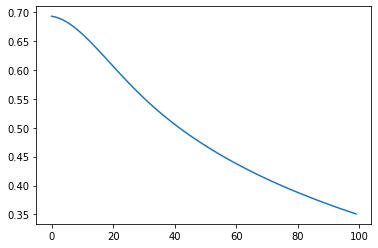

In [683]:
plt.plot(m_t_losses)

In [ ]:
m_g_model.save_weights('./save_weights/m_g_model_weights.h5')

In [684]:
m_t_model.save_weights('./save_weights/m_t_model_weights.h5')

### User Movie Embedding 모델 학습

In [ ]:
MAX_EPOCH = 150
INIT_USER_BATCH_SIZE = 64
FINAL_USER_BATCH_SIZE = 1024

In [ ]:
u_m_model = UserMovieEmbedding(LEN_USERS, EMBEDDING_SIZE)

In [ ]:
u_m_model([np.zeros((1)),np.zeros((1,100))])
u_m_model.summary()

In [ ]:
# optimizer
optimizer = tf.keras.optimizers.Adam()
# loss
bce = tf.keras.losses.BinaryCrossentropy()

In [ ]:
u_m_train_loss = tf.keras.metrics.Mean(name='train_loss')
u_m_train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')


@tf.function
def u_m_train_step(u_m_inputs, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = u_m_model(u_m_inputs, training=True)
        loss = bce(labels, predictions)
    gradients = tape.gradient(loss, u_m_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, u_m_model.trainable_variables))

    u_m_train_loss(loss)
    u_m_train_accuracy(labels, predictions)

In [ ]:
# for log
u_m_losses = []

for epoch in range(MAX_EPOCH):
    
    batch_size = INIT_USER_BATCH_SIZE * (epoch+1)
    if batch_size > FINAL_USER_BATCH_SIZE:
        batch_size = FINAL_USER_BATCH_SIZE
    u_m_generator = generate_user_movie_batch(u_m_pairs, batch_size)
    
    for step in range(len(user_movie_rating_df)//batch_size):
        # embedding layer update
        u_batch, m_batch, u_m_label_batch = next(u_m_generator)
        m_batch = m_g_model.get_layer('movie_embedding')(m_batch)
        u_m_train_step([u_batch, m_batch], u_m_label_batch)
        
        print(f'{epoch} epoch, Batch size : {batch_size}, {step} steps, Loss: {u_m_train_loss.result():0.4f}, Accuracy: {u_m_train_accuracy.result() * 100:0.1f}', end='\r')

    u_m_losses.append(u_m_train_loss.result())

In [ ]:
plt.plot(u_m_losses)

In [ ]:
u_m_model.save_weights('./save_weights/u_m_model_weights.h5')

### 시각화 

In [ ]:
# # 모델 가중치 불러오기
# model.load_weights('./save_weights/embedding_24epoch.h5')

In [ ]:
# embedded movie dataframe 만들기
embedded_movie = movies_genres_df['MovieID'].apply(m_g_t_model.get_layer('movie_embedding'))
columns = [x for x in range(100)]
embedded_movie_df = pd.DataFrame(columns = columns)
for data in embedded_movie:
    embedded_movie_df = embedded_movie_df.append(pd.Series(data), ignore_index=True)
embedded_movie_df.head()

In [ ]:
# PCA를 이용한 차원 축소
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

movie_scaled = StandardScaler().fit_transform(embedded_movie_df)
pca = PCA(n_components=2)
pca.fit(movie_scaled)
movie_pca = pca.transform(movie_scaled)
pca_columns=[f'{n}' for n in range(2)]
movie_df_pca = pd.DataFrame(movie_pca,columns=pca_columns)
movie_df_pca = pd.concat([movie_df_pca, movies_df["Title"]], axis=1)
movie_df_pca = pd.concat([movie_df_pca, movies_df["Genres"]], axis=1)
movie_df_pca.head()

In [ ]:
# 시각화
fig = px.scatter(movie_df_pca, x='0', y='1', color='Genres')
fig.show()

In [ ]:
# T-SNE를 이용한 차원 축소
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(embedded_movie_df)
tsne_df = pd.DataFrame({'x': tsne[:, 0], 'y':tsne[:, 1]})
tsne_df = pd.concat([tsne_df, movies_df["Title"]], axis=1)
tsne_df = pd.concat([tsne_df, movies_df["Genres"]], axis=1)
tsne_df.head()

In [ ]:
# 시각화
fig = px.scatter(tsne_df, x='x', y='y', color='Genres')
fig.show()

In [ ]:
# embedded user dataframe 만들기
embedded_user = users_df['UserID'].apply(np.int32).apply(u_m_model.get_layer('user_embedding'))
columns = [x for x in range(100)]
embedded_user_df = pd.DataFrame(columns = columns)
for data in embedded_user:
    embedded_user_df = embedded_user_df.append(pd.Series(data.numpy()), ignore_index=True)
embedded_user_df.head()

In [ ]:
users_df.head()

In [ ]:
# PCA를 이용한 차원 축소
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

user_scaled = StandardScaler().fit_transform(embedded_user_df)
pca = PCA(n_components=2)
pca.fit(user_scaled)
user_pca = pca.transform(user_scaled)
pca_columns=[f'{n}' for n in range(2)]
user_df_pca = pd.DataFrame(user_pca,columns=pca_columns)
user_df_pca = pd.concat([user_df_pca, users_df["Gender"]], axis=1)
user_df_pca = pd.concat([user_df_pca, users_df["Age"]], axis=1)
user_df_pca = pd.concat([user_df_pca, users_df["Zip-code"]], axis=1)
user_df_pca.head()

In [ ]:
# 시각화
fig = px.scatter(user_df_pca, x='0', y='1', hover_data=user_df_pca)
fig.show()

In [ ]:
# T-SNE를 이용한 차원 축소
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(embedded_user_df)
tsne_df = pd.DataFrame({'x': tsne[:, 0], 'y':tsne[:, 1]})
tsne_df = pd.concat([tsne_df, users_df["Gender"]], axis=1)
tsne_df = pd.concat([tsne_df, users_df["Age"]], axis=1)
tsne_df = pd.concat([tsne_df, users_df["Zip-code"]], axis=1)
tsne_df.head()

In [ ]:
# 시각화
fig = px.scatter(tsne_df, x='x', y='y', hover_data=tsne_df)
fig.show()

##  Case2.

In [ ]:
LEN_MOVIES = max(movies_genres_df["MovieID"])+1
LEN_GENRES = len(genres)+1
LEN_USERS = max(user_movie_rating_df['UserID'])+1
EMBEDDING_SIZE = 100

In [ ]:
class TestUserMovieEmbedding(tf.keras.Model):
    def __init__(self, len_users, len_movies, embedding_size):
        super(TestUserMovieEmbedding, self).__init__()
        self.m_u_input = InputLayer(name='input_layer', input_shape=(2,))
        # embedding
        self.u_embedding = Embedding(name='user_embedding', input_dim=len_users, output_dim=embedding_size)
        self.m_embedding = Embedding(name='movie_embedding', input_dim=len_movies, output_dim=embedding_size)
        # dot product
        self.m_u_merge = Dot(name='movie_user_dot', normalize=False, axes=1)
        # output
        self.m_u_fc = Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.m_u_input(x)
        uemb = self.u_embedding(x[0])
        memb = self.m_embedding(x[1])
        m_u = self.m_u_merge([memb, uemb])
        return self.m_u_fc(m_u)

In [ ]:
MAX_EPOCH = 150
INIT_USER_BATCH_SIZE = 64
FINAL_USER_BATCH_SIZE = 1024

In [ ]:
test_model = TestUserMovieEmbedding(LEN_USERS, LEN_MOVIES, EMBEDDING_SIZE)

test_model([np.zeros((1)),np.zeros((1))])
test_model.summary()

In [ ]:
# optimizer
optimizer = tf.keras.optimizers.Adam()
# loss
bce = tf.keras.losses.BinaryCrossentropy()

In [ ]:
test_train_loss = tf.keras.metrics.Mean(name='train_loss')
test_train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')


@tf.function
def test_train_step(test_inputs, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = test_model(test_inputs, training=True)
        loss = bce(labels, predictions)
    gradients = tape.gradient(loss, test_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, test_model.trainable_variables))

    test_train_loss(loss)
    test_train_accuracy(labels, predictions)

In [ ]:
# for log
test_losses = []

for epoch in range(MAX_EPOCH):
    
    batch_size = INIT_USER_BATCH_SIZE * (epoch+1)
    if batch_size > FINAL_USER_BATCH_SIZE:
        batch_size = FINAL_USER_BATCH_SIZE
    test_generator = generate_user_movie_batch(u_m_pairs, batch_size)
    
    for step in range(len(user_movie_rating_df)//batch_size):
        # embedding layer update
        u_batch, m_batch, u_m_label_batch = next(test_generator)
        test_train_step([u_batch, m_batch], u_m_label_batch)
        
        print(f'{epoch} epoch, Batch size : {batch_size}, {step} steps, Loss: {test_train_loss.result():0.4f}, Accuracy: {test_train_accuracy.result() * 100:0.1f}', end='\r')

    test_losses.append(test_train_loss.result())

In [ ]:
# embedded movie dataframe 만들기
embedded_movie = movies_genres_df['MovieID'].apply(test_model.get_layer('movie_embedding'))
columns = [x for x in range(100)]
embedded_movie_df = pd.DataFrame(columns = columns)
for data in embedded_movie:
    embedded_movie_df = embedded_movie_df.append(pd.Series(data), ignore_index=True)
embedded_movie_df.head()

# PCA를 이용한 차원 축소
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

movie_scaled = StandardScaler().fit_transform(embedded_movie_df)
pca = PCA(n_components=2)
pca.fit(movie_scaled)
movie_pca = pca.transform(movie_scaled)
pca_columns=[f'{n}' for n in range(2)]
movie_df_pca = pd.DataFrame(movie_pca,columns=pca_columns)
movie_df_pca = pd.concat([movie_df_pca, movies_df["Title"]], axis=1)
movie_df_pca = pd.concat([movie_df_pca, movies_df["Genres"]], axis=1)
movie_df_pca.head()

# 시각화
fig = px.scatter(movie_df_pca, x='0', y='1', color='Genres')
fig.show()

In [ ]:
# T-SNE를 이용한 차원 축소
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(embedded_movie_df)
tsne_df = pd.DataFrame({'x': tsne[:, 0], 'y':tsne[:, 1]})
tsne_df = pd.concat([tsne_df, movies_df["Title"]], axis=1)
tsne_df = pd.concat([tsne_df, movies_df["Genres"]], axis=1)
tsne_df.head()

# 시각화
fig = px.scatter(tsne_df, x='x', y='y', color='Genres')
fig.show()

In [ ]:
# embedded user dataframe 만들기
embedded_user = users_df['UserID'].apply(np.int32).apply(test_model.get_layer('user_embedding'))
columns = [x for x in range(100)]
embedded_user_df = pd.DataFrame(columns = columns)
for data in embedded_user:
    embedded_user_df = embedded_user_df.append(pd.Series(data.numpy()), ignore_index=True)
embedded_user_df.head()

In [ ]:
# T-SNE를 이용한 차원 축소
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2).fit_transform(embedded_user_df)
tsne_df = pd.DataFrame({'x': tsne[:, 0], 'y':tsne[:, 1]})
tsne_df = pd.concat([tsne_df, users_df["Gender"]], axis=1)
tsne_df = pd.concat([tsne_df, users_df["Age"]], axis=1)
tsne_df = pd.concat([tsne_df, users_df["Zip-code"]], axis=1)
tsne_df.head()

In [ ]:
# 시각화
fig = px.scatter(tsne_df, x='x', y='y', color='Age', hover_data=tsne_df)
fig.show()

In [ ]:
test_model.save_weights('./save_weights/user_movie_at_once.h5')